In [2]:
#Loading up all libraries
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
# import cv2  
import datetime

Using TensorFlow backend.


In [3]:
# dimensions of our images.  
img_width, img_height = 224, 224  
   
top_model_weights_path = 'bottleneck_fc_model.h5'  
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 100  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [4]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')  


In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)  

# Creation of weights/features with VGG16

In [ ]:
start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

In [ ]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

In [ ]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

## Start from here

### Loading training, validation and testing

In [6]:
start = datetime.datetime.now()
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 13412 images belonging to 6 classes.
Time:  0:00:04.782292


In [7]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2549 images belonging to 6 classes.


In [8]:
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 1845 images belonging to 6 classes.


### Training of model

In [9]:
num_classes

6

In [11]:
train_data.shape

(13412, 7, 7, 512)

In [118]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=6,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 13412 samples, validate on 2549 samples
Epoch 1/6
13412/13412 [==============================] - 36s 3ms/step - loss: 1.3632 - acc: 0.7016 - val_loss: 0.5017 - val_acc: 0.8403
Epoch 2/6
13412/13412 [==============================] - 26s 2ms/step - loss: 0.5025 - acc: 0.8343 - val_loss: 0.5958 - val_acc: 0.8015
Epoch 3/6
13412/13412 [==============================] - 26s 2ms/step - loss: 0.4219 - acc: 0.8650 - val_loss: 0.3181 - val_acc: 0.8964
Epoch 4/6
13412/13412 [==============================] - 25s 2ms/step - loss: 0.3616 - acc: 0.8853 - val_loss: 0.5137 - val_acc: 0.8541
Epoch 5/6
13412/13412 [==============================] - 25s 2ms/step - loss: 0.3238 - acc: 0.8969 - val_loss: 0.3309 - val_acc: 0.9082
Epoch 6/6
2549/2549 [==============================] - 1s 328us/step
[INFO] accuracy: 90.86%
[INFO] Loss: 0.34773845778885615
Time:  0:02:44.808515


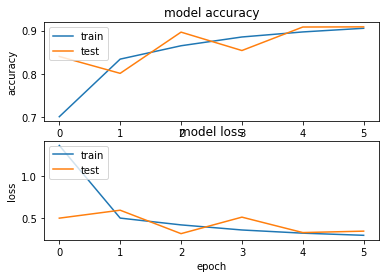

In [120]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

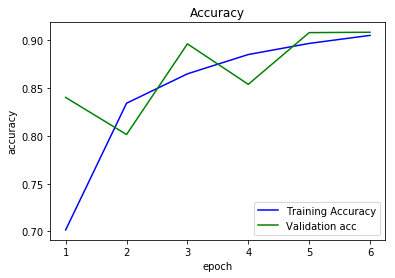

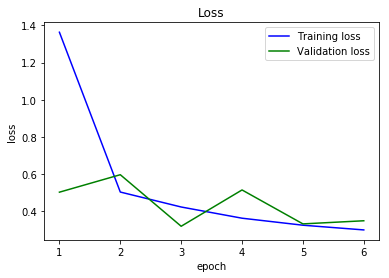

In [121]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'b', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch') 
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'b', label='Training loss')
plt.plot(epch, val_loss, 'g', label='Validation loss')
plt.title('Loss')
plt.ylabel('loss')  
plt.xlabel('epoch') 
plt.legend()
plt.show()

In [122]:
model.evaluate(test_data, test_labels)

1845/1845 [==============================] - 2s 851us/step


[0.32205395769620654, 0.9138211382436882]

In [36]:
import matplotlib.image as mpimg

In [119]:
def read_image(file_path, resize=True):
    image_path = file_path

    orig = mpimg.imread(image_path)  

    print("[INFO] loading and preprocessing image...")  
    image = load_img(image_path, target_size=(224, 224))  
    image = img_to_array(image)  

    # important! otherwise the predictions will be '0'
    if resize:
        image = image / 255  

    image = np.expand_dims(image, axis=0)
    return image

In [80]:
path = 'data/test/elephants/OIP-VC6pX0aP4-OEoBF2nO997wHaIS.jpeg'

In [81]:
image_pred = read_image(path)

[INFO] loading and preprocessing image...


In [145]:
# # build the VGG16 network  
# model = applications.VGG16(include_top=False, weights='imagenet')  

# get the bottleneck prediction from the pre-trained VGG16 model  
bottleneck_prediction = vgg16.predict(image_pred)  

# Rebuilds top model using weights....
# build top model  
model = Sequential()  
model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  

model.load_weights(top_model_weights_path)  

# use the bottleneck prediction on the top model to get the final classification  
class_predicted = model.predict_classes(bottleneck_prediction)

In [48]:
inID = class_predicted[0]  

class_dictionary = generator_top.class_indices  

inv_map = {v: k for k, v in class_dictionary.items()}  

label = inv_map[inID]  

# get the prediction label  
print("Image ID: {}, Label: {}".format(inID, label))  

Image ID: 2, Label: elephants


<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
(224, 224, 3)


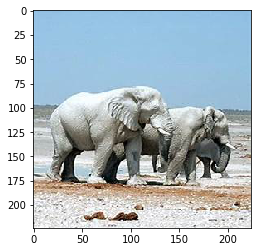

In [49]:
from keras.preprocessing import image

# img = np.random.rand(224,224,3)
# plt.imshow(img)
# plt.show()

img_path = path
img = image.load_img(img_path, target_size=(224, 224))
print(type(img))

x = image.img_to_array(img)
print(type(x))
print(x.shape)
plt.imshow(x/255.)


In [32]:
class_dictionary

{'butterflies': 0,
 'chickens': 1,
 'elephants': 2,
 'horses': 3,
 'spiders': 4,
 'squirells': 5}

# Using SHAP

In [103]:
import shap
import numpy as np
from keras.applications.vgg16 import preprocess_input

In [106]:
model.layers

[<keras.layers.core.Flatten at 0xba05469e8>,
 <keras.layers.core.Dense at 0xba0546a20>,
 <keras.layers.core.Dropout at 0xba0546a58>,
 <keras.layers.core.Dense at 0xb2521b240>]

In [116]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# # load pre-trained model and choose two images to explain
# model = VGG16(weights='imagenet', include_top=True)
# X,y = shap.datasets.imagenet50()
# to_explain = X[[39,41]]

# # load the ImageNet class names
# url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# fname = shap.datasets.cache(url)
# with open(fname) as f:
#     class_names = json.load(f)

In [146]:
to_explain[0].shape

(224, 224, 3)

In [149]:
X = read_image(path)[0]

[INFO] loading and preprocessing image...


In [150]:
X.shape

(224, 224, 3)

In [151]:
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], 
                         [preprocess_input(x.copy())]
                        ))
    
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [152]:
len(model.layers)

4

In [153]:
e = shap.GradientExplainer(
                        (model.layers[3].input, 
                         model.layers[-1].output),
                         map2layer(X, 3),
                         local_smoothing=0 # std dev of smoothing noise
                            )

ValueError: Cannot feed value of shape (224, 224, 3) for Tensor 'flatten_12_input:0', which has shape '(?, 7, 7, 512)'

In [142]:
shap_values,indexes = e.shap_values(map2layer(to_explain, 3), 
                                    ranked_outputs=2)

ValueError: Cannot feed value of shape (2, 224, 224, 3) for Tensor 'flatten_11_input:0', which has shape '(?, 7, 7, 512)'

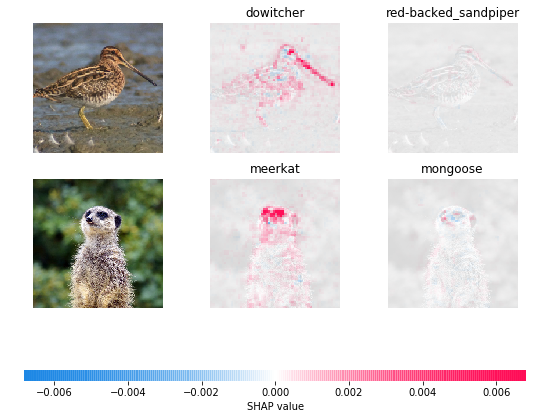

In [143]:
# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

# LIME

In [1]:
import os, sys, lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

KeyboardInterrupt: 

In [ ]:
animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']

In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x /= 255.
        out.append(x)
    return np.vstack(out)

In [ ]:
images = transform_img_fn([os.path.join('data','test/horses/OIP-u299aUBwmPRT_O-rjmCVEwHaGT.jpeg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
preds = model.predict_proba(images)
for idx, animal, x in zip(range(0,6), animals , preds[0]):
    print(idx,' ', animal, ' : ', x)

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(images[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
# Only shows 5 most important places of why it was chosen as that label
temp, mask = explanation.get_image_and_mask(3, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
# pros and cons of category
temp, mask = explanation.get_image_and_mask(3, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))